Prepare fasttext file

In [1]:
import pandas as pd
data = pd.read_json("bcs_polsent.jsonl", orient="records", lines=True)
data.columns

Index(['sentence', 'country', 'type', 'annotator1', 'annotator2', 'gold',
       'reconciliation_hard', 'id_meta', 'term', 'doc_id', 'sentence_id',
       'date', 'fullname', 'party', 'gender', 'yob', 'edu_y', 'ideology',
       'no_seats', 'ruling', 'label', 'origin', 'split'],
      dtype='object')

In [2]:
data = data.loc[ :, ["sentence", "label", "split", "country"]]


In [3]:
train = data[data.split=="train"]
test = data[data.split=="test"]
dev = data[data.split=="dev"]

In [4]:
!mkdir fasttext_data

mkdir: cannot create directory ‘fasttext_data’: File exists


In [5]:
with open("fasttext_data/train.txt", "w") as f:
    for i, row in train.iterrows():
        f.write(f"__label__{row['label']} {row['sentence']}\n")
with open("fasttext_data/test.txt", "w") as f:
    for i, row in test.iterrows():
        f.write(f"__label__{row['label']} {row['sentence']}\n")
with open("fasttext_data/dev.txt", "w") as f:
    for i, row in dev.iterrows():
        f.write(f"__label__{row['label']} {row['sentence']}\n")

In [6]:
import fasttext

Fasttext embeddings obtained from http://hdl.handle.net/11356/1205

In [12]:
import numpy as np
from sklearn.metrics import f1_score
f1s = []
for i in range(50):
    model = fasttext.train_supervised(input="fasttext_data/train.txt", epoch = 16)
    y_pred = model.predict(test.sentence.tolist())[0]
    y_pred = [i[0][9:] for i in y_pred]
    y_true = test.label.tolist()

    f1 = f1_score(
        y_true, y_pred, average="macro", labels=["Positive", "Neutral", "Negative"]
    )
    f1s.append(f1)

print(f"macro f1 on test: {np.mean(f1s):0.4f} +/- {np.std(f1s):0.4f}, sample of {len(f1s)}")

macro f1 on test: 0.4715 +/- 0.0090, sample of 50


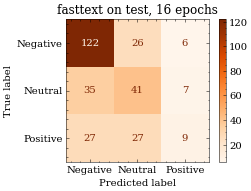

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
plt.style.use("science no-latex".split())

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred, cmap="Oranges", labels=["Negative", "Neutral", "Positive"])
plt.title("fasttext on test, 16 epochs")
plt.savefig("images/004_CM_fasttext.png")
plt.savefig("images/004_CM_fasttext.pdf")
plt.show()

In [10]:
import numpy as np
from sklearn.metrics import f1_score

f1s = []
from tqdm.auto import tqdm
for i in tqdm(range(10)):
    model = fasttext.train_supervised(
        input="fasttext_data/train.txt",
        epoch=5,
        pretrainedVectors="fasttext_embeddings/embed.hr-token.ft.sg.vec",
    )
    y_pred = model.predict(test.sentence.tolist())[0]
    y_pred = [i[0][9:] for i in y_pred]
    y_true = test.label.tolist()

    f1 = f1_score(
        y_true, y_pred, average="macro", labels=["Positive", "Neutral", "Negative"]
    )
    f1s.append(f1)

print(
    f"macro f1 with embeddings on test: {np.mean(f1s):0.4f} +/- {np.std(f1s):0.4f}, sample of {len(f1s)}"
)


  0%|          | 0/10 [00:00<?, ?it/s]

macro f1 with embeddings on test: 0.6312 +/- 0.0043, sample of 10


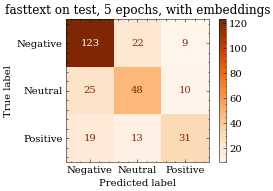

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
plt.style.use("science no-latex".split())

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred, cmap="Oranges", labels=["Negative", "Neutral", "Positive"])
plt.title("fasttext on test, 5 epochs, with embeddings")
plt.savefig("images/004_CM_fasttext_with_embeddings.png")
plt.savefig("images/004_CM_fasttext_with_embeddings.pdf")
plt.show()

# Fasttext trained on specific language

Pars prima: prepare new data

In [14]:
train.country.unique()

array(['BiH', 'HR', 'SRB'], dtype=object)

In [16]:

for split in ["train","test"]:
    for lang in ["HR", "SRB"]:
        condition = eval(split).country == lang
        with open(f"fasttext_data/{split}_{lang}.txt", "w") as f:
            for i, row in eval(split)[condition].iterrows():
                f.write(f"__label__{row['label']} {row['sentence']}\n")

In [30]:
results = []
from tqdm.auto import tqdm
for i in tqdm(range(50)):
    for train_lang in ["HR", "SRB"]:
        train_file = f"fasttext_data/train_{train_lang}.txt"
        model = fasttext.train_supervised(
            input=train_file,
            epoch=16,
        )
        for eval_lang in ["HR", "SRB"]:
            eval_df = test[test.country == eval_lang]
            y_pred = model.predict(eval_df.sentence.tolist())[0]
            y_pred = [i[0][9:] for i in y_pred]
            y_true = eval_df.label.tolist()

            f1 = f1_score(
                y_true, y_pred, average="macro", labels=["Positive", "Neutral", "Negative"]
            )
            results.append(
                {
                    "train_lang": train_lang,
                    "eval_lang": eval_lang,
                    "f1": f1
                }
            )
import pandas as pd
df = pd.DataFrame(data=results)
df.groupby(["train_lang", "eval_lang"]).agg(lambda i: f"{np.mean(i):0.4f} +/- {np.std(i):0.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

f1
train_lang eval_lang                   
HR         HR         0.4133 +/- 0.0093
           SRB        0.3958 +/- 0.0150
SRB        HR         0.3151 +/- 0.0103
           SRB        0.2609 +/- 0.0164

In [29]:
results_emb = []
from tqdm.auto import tqdm
for i in tqdm(range(5)):
    for train_lang in ["HR", "SRB"]:
        train_file = f"fasttext_data/train_{train_lang}.txt"
        model = fasttext.train_supervised(
            input=train_file,
            epoch=5,
            pretrainedVectors="fasttext_embeddings/embed.hr-token.ft.sg.vec",
        )
        for eval_lang in ["HR", "SRB"]:
            eval_df = test[test.country == eval_lang]
            y_pred = model.predict(eval_df.sentence.tolist())[0]
            y_pred = [i[0][9:] for i in y_pred]
            y_true = eval_df.label.tolist()

            f1 = f1_score(
                y_true, y_pred, average="macro", labels=["Positive", "Neutral", "Negative"]
            )
            results_emb.append(
                {
                    "train_lang": train_lang,
                    "eval_lang": eval_lang,
                    "f1": f1
                }
            )
df_emb = pd.DataFrame(data=results_emb).groupby(["train_lang", "eval_lang"]).agg(lambda i: f"{np.mean(i):0.4f} +/- {np.std(i):0.4f}")
df_emb

  0%|          | 0/5 [00:00<?, ?it/s]

f1
train_lang eval_lang                   
HR         HR         0.6379 +/- 0.0097
           SRB        0.6356 +/- 0.0073
SRB        HR         0.6194 +/- 0.0029
           SRB        0.5781 +/- 0.0098

In [34]:
from sklearn.metrics import f1_score
f1s = []
for i in range(5):
    model = fasttext.train_supervised(input="fasttext_data/train_SRB.txt", epoch = 5,
    pretrainedVectors="fasttext_embeddings/embed.hr-token.ft.sg.vec")
    y_pred = model.predict(test[test.country == "SRB"].sentence.tolist())[0]
    y_pred = [i[0][9:] for i in y_pred]
    y_true = test[test.country=="SRB"].label.tolist()

    f1 = f1_score(
        y_true, y_pred, average="macro", labels=["Positive", "Neutral", "Negative"]
    )
    f1s.append(f1)

print(f"macro f1 on test, SRB SRB: {np.mean(f1s):0.4f} +/- {np.std(f1s):0.4f}, sample of {len(f1s)}")

macro f1 on test, SRB SRB: 0.5828 +/- 0.0047, sample of 5


In [37]:
pd.set_option("display.max_rows", None)
test[test.country == "SRB"].shape

(119, 4)